In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from scipy.stats import norm
import os

In [2]:
# make grid of azimuth (theta) and elevation (alpha) coordinates
res = 20
    
# full res lattice sampling azimuth and elevation
theta_mat,alpha_mat = np.meshgrid(np.linspace(-np.pi,np.pi,int(res),endpoint=False),
                                np.linspace(-np.pi/2,np.pi/2,int(res/2),endpoint=False))

# flatten matrices
thetas = theta_mat.flatten()
alphas = alpha_mat.flatten()

# remove points where alpha = -pi/2
thetas = thetas[alphas > -np.pi/2]
alphas = alphas[alphas > -np.pi/2]

# generate masks for subsampling visual field

# indices for full field sampling
fullfield_inds = np.arange(0,np.size(thetas),2)

for i in np.arange(0,90,20):
    fullfield_inds[i:i+10] = fullfield_inds[i:i+10]+1


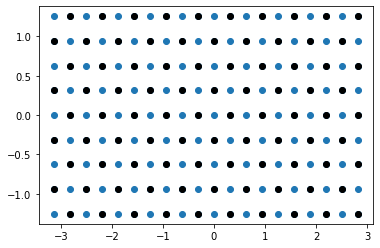

In [3]:
# show that full field sampling is taking every other sample
plt.scatter(thetas,alphas)
plt.scatter(thetas[fullfield_inds],alphas[fullfield_inds],color='black')

In [4]:
# function for determining scene depth geometry
def nearness(geometry='sphere',theta=thetas,alpha=alphas,r=1):
    if geometry == 'sphere':
        mu = 1/r*np.ones_like(theta)
    elif geometry == 'floor':
        mu = np.abs(np.sin(alpha))/r * (alpha < 0)
    return mu

# equations slightly modified (signs and axis labels changed) from
# eqn 2.13 and following matrices in
# http://www.cds.caltech.edu/~murray/preprints/humbert05-phd.pdf
def tangentialflow(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,geometry='sphere',theta=thetas,alpha=alphas,r=1,theta0=0,alpha0=0):
    mu = nearness(geometry=geometry,theta=theta,alpha=alpha,r=r)
    flow_horiz = -np.sin(alpha)*np.cos(theta)*Wz + \
                 np.sin(alpha)*np.sin(theta)*Wx + \
                 -np.cos(alpha)*Wy + \
                 mu*(np.sin(theta)*Vz + np.cos(theta)*Vx)
    flow_vert = np.sin(theta)*Wz + \
                np.cos(theta)*Wx + \
                mu*(np.sin(alpha)*np.cos(theta)*Vz + \
                          -np.sin(alpha)*np.sin(theta)*Vx + \
                          np.cos(alpha)*Vy)
    return flow_horiz, flow_vert


In [5]:
# predict velocity from flow with weighted least squares
def getvel(flow,theta=thetas,alpha=alphas,geometry='sphere',DOFs=6,weights=0):
    
    # if no weights were given, assume uniform
    if np.size(weights) == 1:
        weights=np.ones(len(theta))
        
    vxtemplate = np.ndarray.flatten(np.array(tangentialflow(Vx=1,theta=theta,alpha=alpha,geometry=geometry)))
    vytemplate = np.ndarray.flatten(np.array(tangentialflow(Vy=1,theta=theta,alpha=alpha,geometry=geometry)))
    vztemplate = np.ndarray.flatten(np.array(tangentialflow(Vz=1,theta=theta,alpha=alpha,geometry=geometry)))
    wxtemplate = np.ndarray.flatten(np.array(tangentialflow(Wx=1,theta=theta,alpha=alpha,geometry=geometry)))
    wytemplate = np.ndarray.flatten(np.array(tangentialflow(Wy=1,theta=theta,alpha=alpha,geometry=geometry)))
    wztemplate = np.ndarray.flatten(np.array(tangentialflow(Wz=1,theta=theta,alpha=alpha,geometry=geometry)))
    
    if DOFs == 1:
        templates = vztemplate
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    
    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
    
    # solve for self motion
    pred = np.zeros([6,1])
    pred_DOF,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    
    if DOFs == 1:
        pred[2] = pred_DOF
    elif DOFs == 3:
        pred[0] = pred_DOF[0]  
        pred[2] = pred_DOF[1]  
        pred[4] = pred_DOF[2]  
    elif DOFs == 6:
        pred = pred_DOF
    return np.squeeze(pred)


def anglediff(a,b,deg=True):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

In [6]:
# for a given set of indices (x), runs a batch of self motion trajectories and calculates the errors
# x is a set of indices to use to subset theta/alpha
def error_calc(x,trials=10,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,plotit=False,spatvarnoise=False,weights=0):

    preds = np.nan*np.ones([trials,6])
    gt = np.nan*np.ones([trials,6])
    
    # subset
    this_subset_thetas = thetas[x]
    this_subset_alphas = alphas[x]

    for i in range(trials): 
        Vx,Vy,Vz,Wx,Wy,Wz = np.random.rand(6) # generate random behavior
        
        # zero out irrelevant DOFs
        if DOFs == 3:
            Vy = Wx = Wz = 0
        elif DOFs == 1:
            Vx = Vy = Wx = Wy = Wz = 0
            
        flow = tangentialflow(geometry=geometry,theta=this_subset_thetas,alpha=this_subset_alphas,Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz)
        _,h = np.shape(flow)
        noise = noiselevel*np.random.randn(2*h)
        #noise = np.reshape(noise,[2,h])
        #flow = flow + noise
        noise = np.reshape(noise,[2,h])
        if spatvarnoise:
            noise = noise*((np.tile(-this_subset_alphas,[2,1])+np.pi/2)/(np.pi))
        flow = flow + noise
        
        # get error
        gt[i,:] = [Vx,Vy,Vz,Wx,Wy,Wz]
        preds[i,:] = getvel(flow,geometry=geometry,theta=this_subset_thetas,alpha=this_subset_alphas,DOFs=DOFs,weights=weights)
    
    # return average error (in meters or radians)
    errs = np.median(np.abs(preds-gt),0)
    err_Vz = errs[2]
    
    # heading error (in radians)
    headinggt = np.arctan2(gt[...,2],gt[...,0])
    headingpred = np.arctan2(preds[...,2],preds[...,0])
    headingerr = np.median(np.abs(anglediff(headingpred,headinggt,deg=False)))
    
    errs = np.append(errs,headingerr)
    
    #return err_Vz
    return errs

In [7]:
# run sim a bunch of times
def error_distribution(x,repeats=10,trials=10,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,plotit=False,spatvarnoise=False,weights=0):

    # initialize results        
    all_err         = np.zeros([repeats,7])

    for i in range(repeats):

        errs = error_calc(x,trials=trials,noiselevel=noiselevel,geometry=geometry,theta=theta,alpha=alpha,DOFs=DOFs,spatvarnoise=spatvarnoise,weights=weights)

        all_err[i,:] = errs
    return all_err


In [8]:
# function that creates median split masks and calculated error distribution for best, worst, and full field mask
def prep_histograms(trials=10,repeats=10,DOFs=6,geometry='sphere',spatvarnoise=False,component='Vz'):
    
    
    # load data file with median error at each location
    if spatvarnoise:
        data = np.load(f'./global_median_error_files/global_67pctsparse_0.25noise_spatiallyvaryingnoise_{geometry}_{DOFs}DOFs_10000batchsize_median_errors.npz')
    else:
        data = np.load(f'./global_median_error_files/global_67pctsparse_0.25noise_{geometry}_{DOFs}DOFs_10000batchsize_median_errors.npz')

        
    if component == 'heading':
        median_error = data['median_error_heading']
    elif component == 'Vz':
        median_error = data['median_error_Vz']
    else:
        print('invalid component')
    
    # subset points above and below median error for Vz masks
    best = median_error < np.median(median_error)
    best_inds = np.squeeze(np.where(best == True))
    worst_inds = np.squeeze(np.where(best == False))

    print('total nsamples =', np.size(thetas))
    print('full field nsamples =', np.size(fullfield_inds))
    print('best nsamples =', np.size(best_inds))
    print('worst nsamples =', np.size(worst_inds))

    inds_all = [fullfield_inds,best_inds,worst_inds]
    thetatitles = ['fullfield','best','worst']
    veltitles = ['Vx','Vy','Vz','Wx','Wy','Wz']
    
    
    # visualize mask samples - Vz

    thetas_ff = thetas.copy()
    thetas_ff = thetas[fullfield_inds]
    alphas_ff = alphas.copy()
    alphas_ff = alphas[fullfield_inds]

    plt.figure(figsize=(10,5))
    ax = plt.axes()
    plt.axis('equal')
    plt.scatter(np.append(thetas_ff,-thetas_ff[thetas_ff<-3]),np.append(alphas_ff,alphas_ff[thetas_ff<-3]),color='black')
    ax.set_box_aspect(1/2)
    plt.xlim(-np.pi,np.pi)
    plt.ylim(-np.pi/2,np.pi/2)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    thetas_best = thetas.copy()
    thetas_best = thetas[best_inds]
    alphas_best = alphas.copy()
    alphas_best = alphas[best_inds]

    plt.figure(figsize=(10,5))
    ax = plt.axes()
    plt.axis('equal')
    plt.scatter(np.append(thetas_best,-thetas_best[thetas_best<-3]),np.append(alphas_best,alphas_best[thetas_best<-3]),color='green')
    ax.set_box_aspect(1/2)
    plt.xlim(-np.pi,np.pi)
    plt.ylim(-np.pi/2,np.pi/2)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    if spatvarnoise:
        plt.savefig(f'./global_plots/final_Fig2_{DOFs}DOF_{geometry}_best_sampling_{component}_spatiallyvaryingnoise.png', format='png',dpi=300)
    else:
        plt.savefig(f'./global_plots/final_Fig2_{DOFs}DOF_{geometry}_best_sampling_{component}.png', format='png',dpi=300)

    thetas_worst = thetas.copy()
    thetas_worst = thetas[worst_inds]
    alphas_worst = alphas.copy()
    alphas_worst = alphas[worst_inds]

    plt.figure(figsize=(10,5))
    ax = plt.axes()
    plt.axis('equal')
    plt.scatter(np.append(thetas_worst,-thetas_worst[thetas_worst<-3]),np.append(alphas_worst,alphas_worst[thetas_worst<-3]),color='orange')
    ax.set_box_aspect(1/2)
    plt.xlim(-np.pi,np.pi)
    plt.ylim(-np.pi/2,np.pi/2)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    if spatvarnoise:
        plt.savefig(f'./global_plots/final_Fig2_{DOFs}DOF_{geometry}_worst_sampling_{component}_spatiallyvaryingnoise.png', format='png',dpi=300)
    else:
        plt.savefig(f'./global_plots/final_Fig2_{DOFs}DOF_{geometry}_worst_sampling_{component}.png', format='png',dpi=300)
    
    
    # run simulations
    inds = fullfield_inds
    errors_fullfield = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry=geometry,theta=thetas,alpha=alphas,DOFs=DOFs,spatvarnoise=spatvarnoise)
    errors_fullfield[:,0:3] = 100*errors_fullfield[:,0:3] # convert to cm
    errors_fullfield[:,3:] = (180/np.pi)*errors_fullfield[:,3:] # convert to deg
    
    inds = best_inds
    errors_best = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry=geometry,theta=thetas,alpha=alphas,DOFs=DOFs,spatvarnoise=spatvarnoise)
    errors_best[:,0:3] = 100*errors_best[:,0:3] # convert to cm
    errors_best[:,3:] = (180/np.pi)*errors_best[:,3:] # convert to deg

    inds = worst_inds
    errors_worst = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry=geometry,theta=thetas,alpha=alphas,DOFs=DOFs,spatvarnoise=spatvarnoise)
    errors_worst[:,0:3] = 100*errors_worst[:,0:3] # convert to cm
    errors_worst[:,3:] = (180/np.pi)*errors_worst[:,3:] # convert to deg

    if spatvarnoise:
        np.savez(f'./global_median_error_files/histogram_median_errors_Fig2_{DOFs}DOF_{geometry}_{component}_spatiallyvaryingnoise.npz',errors_fullfield=errors_fullfield,errors_best=errors_best,errors_worst=errors_worst)
    else:
        np.savez(f'./global_median_error_files/histogram_median_errors_Fig2_{DOFs}DOF_{geometry}_{component}.npz',errors_fullfield=errors_fullfield,errors_best=errors_best,errors_worst=errors_worst)


1DOF sphere
total nsamples = 180
full field nsamples = 90
best nsamples = 90
worst nsamples = 90
3DOF sphere
total nsamples = 180
full field nsamples = 90
best nsamples = 90
worst nsamples = 90
3DOF sphere - spatially varying noise
total nsamples = 180
full field nsamples = 90
best nsamples = 90
worst nsamples = 90
3DOF floor - Vz
total nsamples = 180
full field nsamples = 90
best nsamples = 90
worst nsamples = 90
3DOF floor - Heading
total nsamples = 180
full field nsamples = 90
best nsamples = 90
worst nsamples = 90


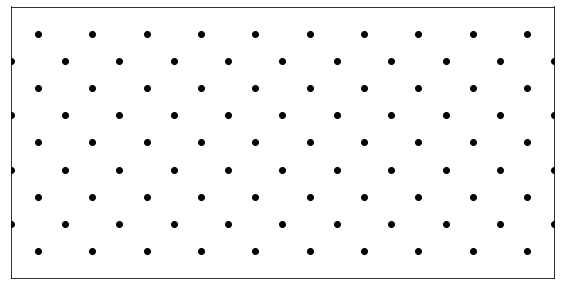

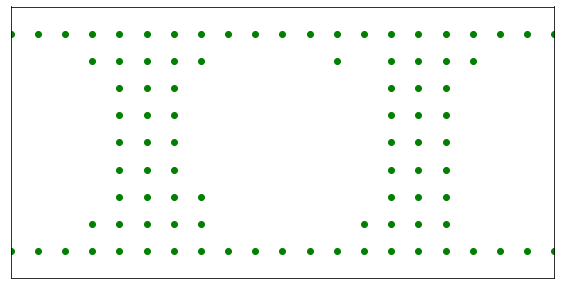

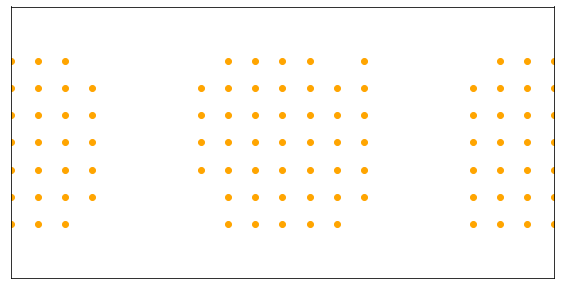

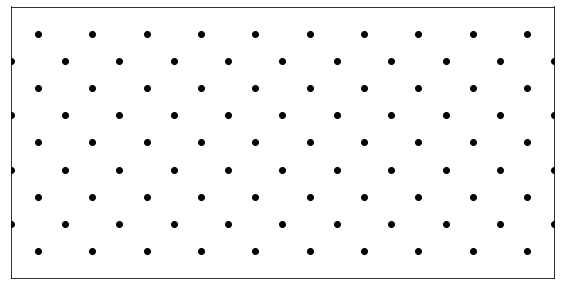

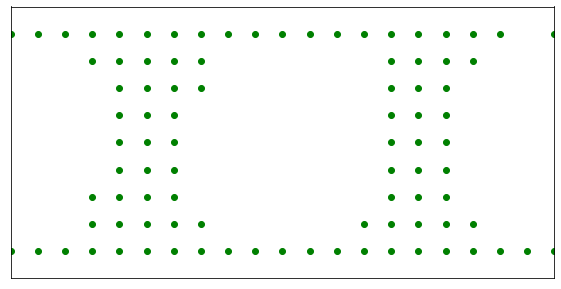

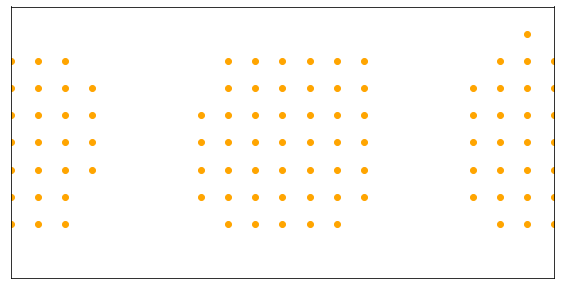

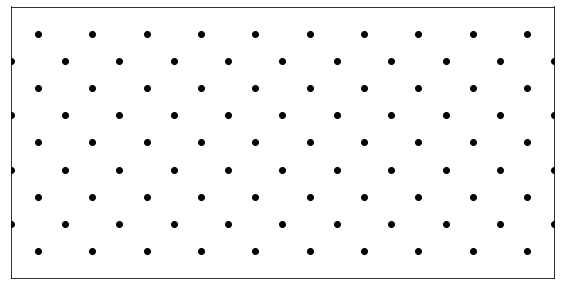

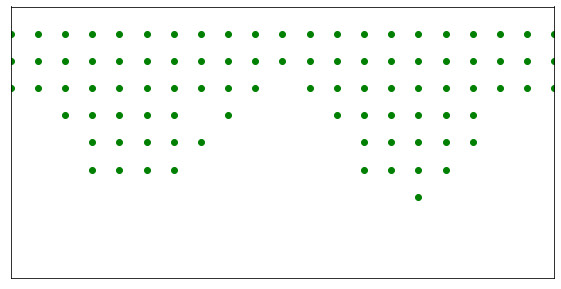

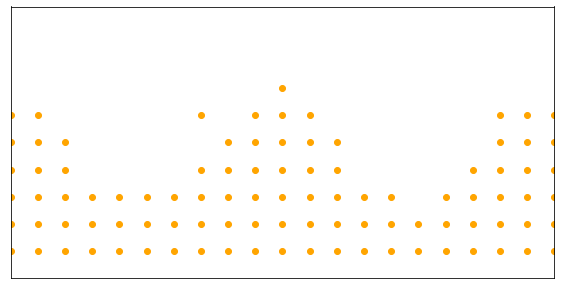

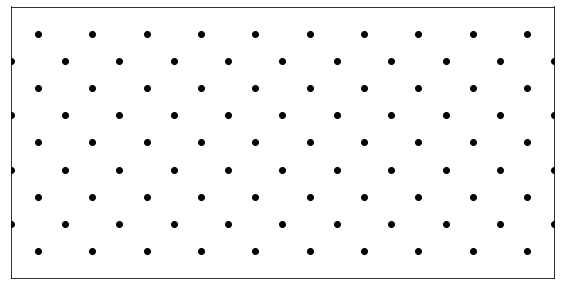

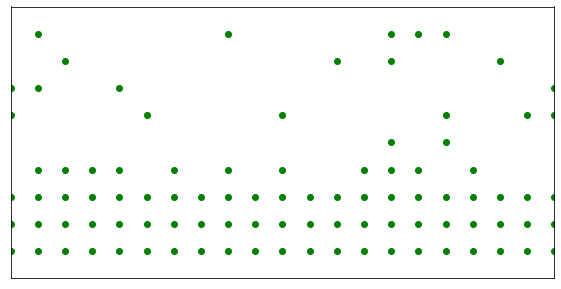

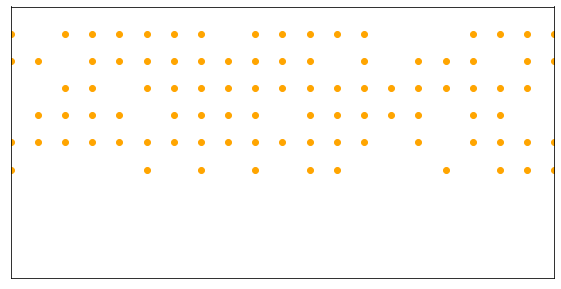

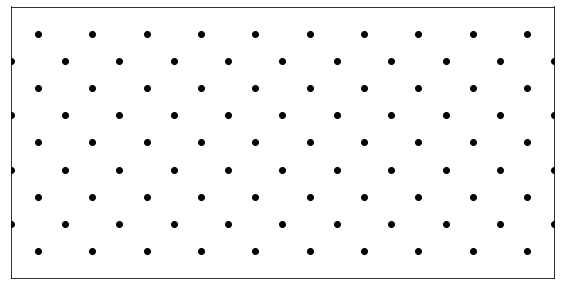

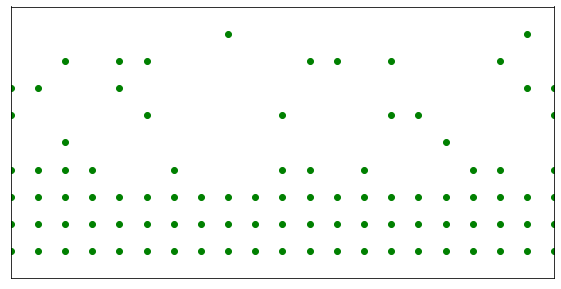

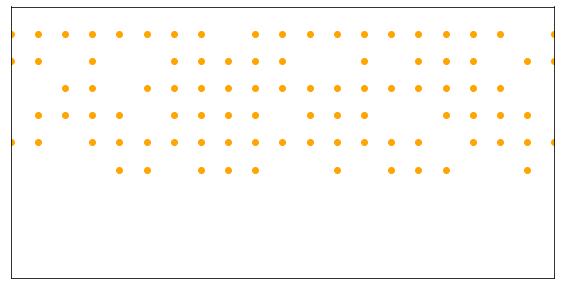

In [9]:
trials=1000
repeats=1000

#trials=1000
#repeats=1000

# 1 DOF sphere
geometry = 'sphere'
DOFs = 1
spatvarnoise = False
component = 'Vz'

print('1DOF sphere')
prep_histograms(trials=trials,repeats=repeats,DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


# 3 DOF sphere
geometry = 'sphere'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('3DOF sphere')
prep_histograms(trials=trials,repeats=repeats,DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


# 3 DOF sphere - spatially varying noise
geometry = 'sphere'
DOFs = 3
spatvarnoise = True
component = 'Vz'

print('3DOF sphere - spatially varying noise')
prep_histograms(trials=trials,repeats=repeats,DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


# 3 DOF floor
geometry = 'floor'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('3DOF floor - Vz')
prep_histograms(trials=trials,repeats=repeats,DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

component = 'heading'
print('3DOF floor - Heading')
prep_histograms(trials=trials,repeats=repeats,DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


In [ ]:
# 3 DOF sphere - spatially varying noise
geometry = 'sphere'
DOFs = 1
spatvarnoise = False
component = 'Vz'

print('3DOF sphere - spatially varying noise')
prep_histograms(trials=trials,repeats=repeats,DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


In [87]:
# plot histograms
def plot_histograms(DOFs=6,geometry='sphere',spatvarnoise=False,component='Vz'):
    
    if spatvarnoise:
        data = np.load(f'./global_median_error_files/histogram_median_errors_Fig2_{DOFs}DOF_{geometry}_{component}_spatiallyvaryingnoise.npz')
    else:
        data = np.load(f'./global_median_error_files/histogram_median_errors_Fig2_{DOFs}DOF_{geometry}_{component}.npz')
    
    errors_fullfield = data['errors_fullfield']
    errors_best = data['errors_best']
    errors_worst = data['errors_worst']

    font = {'family' : 'arial',
             'size'   : 6}

    matplotlib.rc('font', **font)

    if component == 'Vz':
        comp_ind = 2
    elif component == 'heading':
        comp_ind = 6
        
    # bounds
    print('best min',np.min(errors_best[:,comp_ind]))
    print('worst max',np.max(errors_worst[:,comp_ind]))

    # set sensible ranges
    if DOFs == 1:
        xmin = 1.5
        xmax = 3
    elif DOFs == 3:
        xmin = 0.5
        xmax = 2
        
        if spatvarnoise==False:
            xmin = 1.5
            xmax = 3
            
        if geometry=='floor':
              
            if component == 'heading':
                xmin = 0
                xmax = 20
            else:
                xmin = 0
                xmax = 40
        
    x = np.linspace(xmin, xmax, 100)

    plt.figure(figsize=(.8,.8))


    plt.hist(errors_fullfield[:,comp_ind],bins=x,label='full-field',alpha=0.5,density=True,color='k')
    mu_fullfield, std_fullfield = norm.fit(errors_fullfield[:,comp_ind])
    p = norm.pdf(x, mu_fullfield, std_fullfield)
    plt.plot(x, p, 'k', linewidth=2)
    print('full field mu = ',mu_fullfield,' std = ',std_fullfield)

    plt.hist(errors_worst[:,comp_ind],bins=x,label='worst',alpha=0.5,density=True,color='orange')
    mu_worst, std_worst = norm.fit(errors_worst[:,comp_ind])
    p = norm.pdf(x, mu_worst, std_worst)
    plt.plot(x, p, 'orange', linewidth=2)
    print('worst mu = ',mu_worst,' std = ',std_worst)

    plt.hist(errors_best[:,comp_ind],bins=x,label='best',alpha=0.5,density=True,color='green')
    mu_best, std_best = norm.fit(errors_best[:,comp_ind])
    p = norm.pdf(x, mu_best, std_best)
    plt.plot(x, p, 'green', linewidth=2)
    print('best mu = ',mu_best,' std = ',std_best)

    if component == 'Vz':
        plt.xlabel('median error (cm/s)')
    elif component == 'heading':
        plt.xlabel('median error (deg)')

    plt.yticks([])
    
    plt.xlim(xmin,xmax)
    
    if DOFs == 1:
        plt.xticks([1.5,2,2.5,3])
    elif DOFs == 3:
        plt.xticks([0.5,1,1.5,2])
        
        if spatvarnoise == False:
            plt.xticks([1.5,2,2.5,3])

        if geometry=='floor':
            
            if component == 'heading':
                plt.xticks([0,5,10,15,20])
            else:
                plt.xticks([0,10,20,30,40])
            
    # dprimes
    print('effect size (D) anti to full',(mu_worst-mu_fullfield)/np.sqrt((np.std(errors_worst[:,comp_ind], ddof=1) ** 2 + np.std(errors_fullfield[:,comp_ind], ddof=1) ** 2) / 2.0) )
    print('effect size (D) best to full',(mu_best-mu_fullfield)/np.sqrt((np.std(errors_best[:,comp_ind], ddof=1) ** 2 + np.std(errors_fullfield[:,comp_ind], ddof=1) ** 2) / 2.0) )

    if spatvarnoise:
        plt.savefig(f'./final_plots/final_fig2_global_histogram_{component}_{geometry}_{DOFs}DOF_spatiallyvaryingnoise.png', format='png',dpi=300)
        plt.savefig(f'./final_plots/final_fig2_global_histogram_{component}_{geometry}_{DOFs}DOF_spatiallyvaryingnoise.eps', format='eps',dpi=300)
      
    else:
        plt.savefig(f'./final_plots/final_fig2_global_histogram_{component}_{geometry}_{DOFs}DOF.png', format='png',dpi=300)
        plt.savefig(f'./final_plots/final_fig2_global_histogram_{component}_{geometry}_{DOFs}DOF.eps', format='eps',dpi=300)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


best min 1.9607846940127223
worst max 19.87203730065823
full field mu =  3.175796112576016  std =  0.124679984358476
worst mu =  17.7496889062306  std =  0.7444342848626557
best mu =  2.2696705053496244  std =  0.08854284500842355
effect size (D) anti to full 27.292273824393927
effect size (D) best to full -8.37564135140775


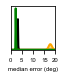

In [88]:
# 1 DOF sphere
geometry = 'floor'
DOFs = 3
spatvarnoise = False
component = 'heading'

plot_histograms(DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)



In [ ]:
errors_fullfield = data['errors_fullfield']
errors_best = data['errors_best']
errors_worst = data['errors_worst']

In [ ]:
data = np.load(f'./global_median_error_files/histogram_median_errors_Fig2_3DOF_sphere_Vz_spatiallyvaryingnoise.npz')


In [ ]:
plt.hist(errors_fullfield[:,2])

1DOF sphere
best min 1.5733313970092588
worst max 2.8112253900191204
full field mu =  2.093030651270936  std =  0.07781938965942568
worst mu =  2.518439223455917  std =  0.09097331493804767
best mu =  1.825491324767336  std =  0.06679235860568523
effect size (D) anti to full 5.022854030815416
effect size (D) best to full -3.687549453982808


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3DOF sphere
best min 1.5943984575138737
worst max 2.808077838560319
full field mu =  2.0978858260219204  std =  0.07923184141107874
worst mu =  2.5163269844126206  std =  0.09231233026617239
best mu =  1.8317978816148832  std =  0.06571642164150297
effect size (D) anti to full 4.8619699404882315
effect size (D) best to full -3.6538031531727393


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3DOF sphere - spatially varying noise
best min 0.5915728554537647
worst max 1.9500108065488575
full field mu =  1.2042165084581873  std =  0.04319715417204985
worst mu =  1.7650409168296364  std =  0.06433715202166157
best mu =  0.6677684625230537  std =  0.02425296157926683
effect size (D) anti to full 10.229599323072929
effect size (D) best to full -15.306306637916853


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3DOF floor - Vz
best min 2.5438158038443155
worst max 31.358609758519773
full field mu =  4.10287724780062  std =  0.15421409559666294
worst mu =  27.636799554605105  std =  1.0317247137013827
best mu =  2.9200213402394697  std =  0.11208417719700704
effect size (D) anti to full 31.888209850875505
effect size (D) best to full -8.770172678756209
3DOF floor - Heading
best min 1.9607846940127223
worst max 19.87203730065823
full field mu =  3.175796112576016  std =  0.124679984358476
worst mu =  17.7496889062306  std =  0.7444342848626557
best mu =  2.2696705053496244  std =  0.08854284500842355
effect size (D) anti to full 27.292273824393927
effect size (D) best to full -8.37564135140775


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


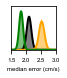

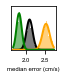

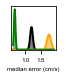

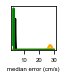

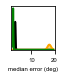

In [22]:
# 1 DOF sphere
geometry = 'sphere'
DOFs = 1
spatvarnoise = False
component = 'Vz'

print('1DOF sphere')
plot_histograms(DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


# 3 DOF sphere
geometry = 'sphere'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('3DOF sphere')
plot_histograms(DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)



# 3 DOF sphere - spatially varying noise
geometry = 'sphere'
DOFs = 3
spatvarnoise = True
component = 'Vz'

print('3DOF sphere - spatially varying noise')
plot_histograms(DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)



# 3 DOF floor
geometry = 'floor'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('3DOF floor - Vz')
plot_histograms(DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

component = 'heading'
print('3DOF floor - Heading')
plot_histograms(DOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


In [ ]:
# DEFUNCT BELOW HERE

In [ ]:
#Vz histograms

data = np.load('./global_median_error_files/histogram_median_errors_Fig2_1DOF_sphere_Vz.npz')
errors_fullfield = data['errors_fullfield']
errors_best = data['errors_best']
errors_worst = data['errors_worst']

font = {'family' : 'arial',
         'size'   : 6}

matplotlib.rc('font', **font)

# bounds
print('best min',np.min(errors_worst))
print('worst max',np.max(errors_best))

xmin = np.min(errors_worst)
xmax = np.max(errors_best)
#xmin=1.5
#xmax = 2.75
x = np.linspace(xmin, xmax, 100)

plt.figure(figsize=(2,1))

#xmin = 0.6
#xmax = 1.2
#x = np.linspace(xmin, xmax, 100)

plt.hist(errors_fullfield[:,2],bins=x,label='full-field',alpha=0.5,density=True,color='k')
mu_fullfield, std_fullfield = norm.fit(errors_fullfield[:,5])
p = norm.pdf(x, mu_fullfield, std_fullfield)
plt.plot(x, p, 'k', linewidth=2)
print('full field mu = ',mu_fullfield,' std = ',std_fullfield)

plt.hist(errors_worst[:,2],bins=x,label='worst',alpha=0.5,density=True,color='orange')
mu_worst, std_worst = norm.fit(errors_worst[:,5])
p = norm.pdf(x, mu_worst, std_worst)
plt.plot(x, p, 'orange', linewidth=2)
print('worst mu = ',mu_worst,' std = ',std_worst)

plt.hist(errors_best[:,2],bins=x,label='best',alpha=0.5,density=True,color='green')
mu_best, std_best = norm.fit(errors_best[:,5])
p = norm.pdf(x, mu_best, std_best)
plt.plot(x, p, 'green', linewidth=2)
print('best mu = ',mu_best,' std = ',std_best)

#plt.legend(prop={'size': 6})
plt.xlabel('median error (cm/s)')
plt.ylabel('probability density')

plt.yticks([])

# dprimes
print('effect size (D) anti to full',(mu_worst-mu_fullfield)/np.sqrt((np.std(errors_worst[:,5], ddof=1) ** 2 + np.std(errors_fullfield[:,5], ddof=1) ** 2) / 2.0) )
print('effect size (D) best to full',(mu_best-mu_fullfield)/np.sqrt((np.std(errors_best[:,5], ddof=1) ** 2 + np.std(errors_fullfield[:,5], ddof=1) ** 2) / 2.0) )

plt.savefig(f'./final_plots/final_fig1_global_histogram_Vz_Fig2_1DOF.png', format='png',dpi=300)
plt.savefig(f'./final_plots/final_fig1_global_histogram_Vz_Fig2_1DOF.eps', format='eps',dpi=300)

In [ ]:
# FIGURE 2 behavior:

# 1 DOF SPHERE

data = np.load('./global_median_error_files/global_67pctsparse_0.25noise_sphere_1DOFs_10000batchsize_median_errors.npz')
median_error_Vz = data['median_error_Vz']

# Vz

# subset points above and below median error for Vz masks
best = median_error_Vz < np.median(median_error_Vz)
best_inds = np.squeeze(np.where(best == True))
worst_inds = np.squeeze(np.where(best == False))

print('total nsamples =', np.size(thetas))
print('full field nsamples =', np.size(fullfield_inds))
print('best nsamples =', np.size(best_inds))
print('worst nsamples =', np.size(worst_inds))

inds_all = [fullfield_inds,best_inds,worst_inds]
thetatitles = ['fullfield','best','worst']
veltitles = ['Vx','Vy','Vz','Wx','Wy','Wz']


In [ ]:
# visualize mask samples - Vz

thetas_ff = thetas.copy()
thetas_ff = thetas[fullfield_inds]
alphas_ff = alphas.copy()
alphas_ff = alphas[fullfield_inds]

plt.figure(figsize=(10,5))
ax = plt.axes()
plt.axis('equal')
plt.scatter(np.append(thetas_ff,-thetas_ff[thetas_ff<-3]),np.append(alphas_ff,alphas_ff[thetas_ff<-3]),color='black')
ax.set_box_aspect(1/2)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi/2,np.pi/2)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)


thetas_best = thetas.copy()
thetas_best = thetas[best_inds]
alphas_best = alphas.copy()
alphas_best = alphas[best_inds]

plt.figure(figsize=(10,5))
ax = plt.axes()
plt.axis('equal')
plt.scatter(np.append(thetas_best,-thetas_best[thetas_best<-3]),np.append(alphas_best,alphas_best[thetas_best<-3]),color='green')
ax.set_box_aspect(1/2)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi/2,np.pi/2)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.savefig(f'./global_plots/final_Fig2_1DOF_sphere_best_sampling.png', format='png',dpi=300)

thetas_worst = thetas.copy()
thetas_worst = thetas[worst_inds]
alphas_worst = alphas.copy()
alphas_worst = alphas[worst_inds]

plt.figure(figsize=(10,5))
ax = plt.axes()
plt.axis('equal')
plt.scatter(np.append(thetas_worst,-thetas_worst[thetas_worst<-3]),np.append(alphas_worst,alphas_worst[thetas_worst<-3]),color='orange')
ax.set_box_aspect(1/2)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi/2,np.pi/2)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.savefig(f'./global_plots/final_Fig2_1DOF_sphere_worst_sampling.png', format='png',dpi=300)




In [ ]:
# run simulations and calculate distribution of errors - Vz

trials=1000
repeats=1000

#trials=1000
#repeats=1000

geometry = 'sphere'
DOFs = 1
spatvarnoise = False

inds = fullfield_inds
errors_fullfield = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry=geometry,theta=thetas,alpha=alphas,DOFs=DOFs,spatvarnoise=spatvarnoise)
errors_fullfield = 100*errors_fullfield # convert to cm

inds = best_inds
errors_best = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry=geometry,theta=thetas,alpha=alphas,DOFs=DOFs,spatvarnoise=spatvarnoise)
errors_best = 100*errors_best # convert to cm

inds = worst_inds
errors_worst = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry=geometry,theta=thetas,alpha=alphas,DOFs=DOFs,spatvarnoise=spatvarnoise)
errors_worst = 100*errors_worst # convert to cm

np.savez('./global_median_error_files/histogram_median_errors_Fig2_1DOF_sphere.npz',errors_fullfield=errors_fullfield,errors_best=errors_best,errors_worst=errors_worst)


In [ ]:
#Vz histograms

data = np.load('./global_median_error_files/histogram_median_errors_Fig2_1DOF_sphere.npz')
errors_fullfield = data['errors_fullfield']
errors_best = data['errors_best']
errors_worst = data['errors_worst']

font = {'family' : 'arial',
         'size'   : 6}

matplotlib.rc('font', **font)

# bounds
print('best min',np.min(errors_worst))
print('worst max',np.max(errors_best))

xmin = np.min(errors_worst)
xmax = np.max(errors_best)
x = np.linspace(xmin, xmax, 100)

plt.figure(figsize=(2,1))

plt.hist(errors_fullfield[:,2],bins=x,label='full-field',alpha=0.5,density=True,color='k')
mu_fullfield, std_fullfield = norm.fit(errors_fullfield[:,5])
p = norm.pdf(x, mu_fullfield, std_fullfield)
plt.plot(x, p, 'k', linewidth=2)
print('full field mu = ',mu_fullfield,' std = ',std_fullfield)


plt.hist(errors_worst[:,2],bins=x,label='worst',alpha=0.5,density=True,color='orange')
mu_worst, std_worst = norm.fit(errors_worst[:,5])
p = norm.pdf(x, mu_worst, std_worst)
plt.plot(x, p, 'orange', linewidth=2)
print('worst mu = ',mu_worst,' std = ',std_worst)

plt.hist(errors_best[:,2],bins=x,label='best',alpha=0.5,density=True,color='green')
mu_best, std_best = norm.fit(errors_best[:,5])
p = norm.pdf(x, mu_best, std_best)
plt.plot(x, p, 'green', linewidth=2)
print('best mu = ',mu_best,' std = ',std_best)


#plt.legend(prop={'size': 6})
plt.xlabel('median error (cm/s)')
plt.ylabel('probability density')

plt.yticks([])

# dprimes
print('effect size (D) anti to full',(mu_worst-mu_fullfield)/np.sqrt((np.std(errors_worst[:,5], ddof=1) ** 2 + np.std(errors_fullfield[:,5], ddof=1) ** 2) / 2.0) )
print('effect size (D) best to full',(mu_best-mu_fullfield)/np.sqrt((np.std(errors_best[:,5], ddof=1) ** 2 + np.std(errors_fullfield[:,5], ddof=1) ** 2) / 2.0) )

plt.savefig(f'./final_plots/final_fig1_global_histogram_Vz_Fig2_1DOF.png', format='png',dpi=300)
plt.savefig(f'./final_plots/final_fig1_global_histogram_Vz_Fig2_1DOF.eps', format='eps',dpi=300)